## CTR Prediction
CTR (Click-Through Rate) prediction estimates the likelihood of a user clicking on an online ad or content. It uses machine learning to analyze user behavior, ad features, and context to predict click probability. Often implemented as a binary classifier, it outputs a probability score indicating whether a click will occur (1) or not (0).

The original dataset can be accessed [here](https://www.kaggle.com/datasets/arashnic/ctr-in-advertisement/data). For an in-depth overview, please refer to the introduction article available [here](https://www.nicoletangsy.com/article/revisiting-machine-learning-fraud-detection).

---
#### Environment Set-up

In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

---
#### Data Understanding

In [2]:
df = pd.read_csv("Ad_click_prediction_train.csv")

In [3]:
# hows the data looks like
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [4]:
# data size
def df_check(df):
    print("DF Size:",df.shape, '\n')

    for col_name, col_type in df.dtypes.items():

        # data type
        print(f"Column: {col_name} ({col_type})")

        # # data unique values
        print(f"Unique Values: {df[col_name].nunique()}") 
        print(f"Values Example: {df[col_name].unique()[:3]}") 

        if col_type in ['float', 'int']:
            # data min max
            print(f"Min. Values: {df[col_name].min()}") 
            print(f"Max. Values: {df[col_name].max()}") 
        else:
            pass

        # missing data
        print(f"NA Values: {df[df[col_name].isna()].shape[0]} ({round((df[df[col_name].isna()].shape[0]/df.shape[0]*100), 2)}%)")

        print('\n')

In [5]:
df_check(df)

DF Size: (463291, 15) 

Column: session_id (int64)
Unique Values: 463291
Values Example: [140690 333291 129781]
Min. Values: 2
Max. Values: 595812
NA Values: 0 (0.0%)


Column: DateTime (object)
Unique Values: 8610
Values Example: ['2017-07-02 00:00' '2017-07-02 00:01' '2017-07-02 00:02']
NA Values: 0 (0.0%)


Column: user_id (int64)
Unique Values: 150347
Values Example: [ 858557  243253 1097446]
Min. Values: 4
Max. Values: 1141729
NA Values: 0 (0.0%)


Column: product (object)
Unique Values: 10
Values Example: ['C' 'I' 'F']
NA Values: 0 (0.0%)


Column: campaign_id (int64)
Unique Values: 10
Values Example: [359520 105960 405490]
Min. Values: 82320
Max. Values: 414149
NA Values: 0 (0.0%)


Column: webpage_id (int64)
Unique Values: 9
Values Example: [13787 11085 60305]
Min. Values: 1734
Max. Values: 60305
NA Values: 0 (0.0%)


Column: product_category_1 (int64)
Unique Values: 5
Values Example: [4 5 3]
Min. Values: 1
Max. Values: 5
NA Values: 0 (0.0%)


Column: product_category_2 (float6

2 variables having lots of NA values: product_category_2 (78.97%), city_development_index(27.01%), we may need to be careful

In [6]:
df['is_click'].value_counts()

is_click
0    431960
1     31331
Name: count, dtype: int64

In [7]:
round((df[df['is_click']==1].shape[0]/df.shape[0])*100, 2)

6.76

The dataset is imbalanced, with only 6.76% of data points in the minority class, necessitating rebalancing for robust model training and cautious evaluation metric selection to avoid masking weaknesses in minority class prediction.

---
#### Data Understanding & EDA 

In [8]:
df.columns

Index(['session_id', 'DateTime', 'user_id', 'product', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click'],
      dtype='object')

In [9]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Day'] = df['DateTime'].dt.date
df['Hour'] = df['DateTime'].dt.hour
df = df.drop(columns=['DateTime'])

In [10]:
# let see whether the CTR related to time
total = pd.DataFrame(df.groupby(['Day',"Hour"])['session_id'].nunique()).reset_index()
total.columns = ['Day',"Hour", "total_session"]

click = pd.DataFrame(df[df['is_click']==1].groupby(['Day',"Hour"])['session_id'].nunique()).reset_index()
click.columns = ['Day',"Hour", "clicked_session"]

ctr = total.merge(click, on=['Day','Hour'], how='left')
ctr['ctr_rate'] = (ctr['clicked_session']/ ctr['total_session'])*100

In [11]:
ctr.sort_values('ctr_rate',ascending=False).head(10)
# top 6 out of top 10 are mid-night

,Day,Hour,total_session,clicked_session,ctr_rate
121,2017-07-07,1,289,27,9.342561
49,2017-07-04,1,189,17,8.994709
24,2017-07-03,0,435,39,8.965517
54,2017-07-04,6,2482,218,8.783239
21,2017-07-02,21,3634,313,8.613099
55,2017-07-04,7,2575,220,8.543689
70,2017-07-04,22,1431,118,8.245982
2,2017-07-02,2,268,22,8.208955
40,2017-07-03,16,3444,281,8.159117
35,2017-07-03,11,4305,350,8.130081


In [12]:
ctr.sort_values('total_session',ascending=False).head(10)
# okay, the high ctr_rate is related to the base

,Day,Hour,total_session,clicked_session,ctr_rate
68,2017-07-04,20,7652,493,6.442760
92,2017-07-05,20,7631,448,5.870790
91,2017-07-05,19,7383,401,5.431396
67,2017-07-04,19,6593,491,7.447293
20,2017-07-02,20,6259,433,6.918038
44,2017-07-03,20,6050,485,8.016529
130,2017-07-07,10,6039,371,6.143401
43,2017-07-03,19,5645,415,7.351639
32,2017-07-03,8,5526,422,7.636627
31,2017-07-03,7,5456,412,7.551320


In [13]:
def plot_histograms(df, columns, bins=30):
    n_cols = len(columns)
    n_rows = math.ceil(n_cols / 2)
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, bins=bins, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
    
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

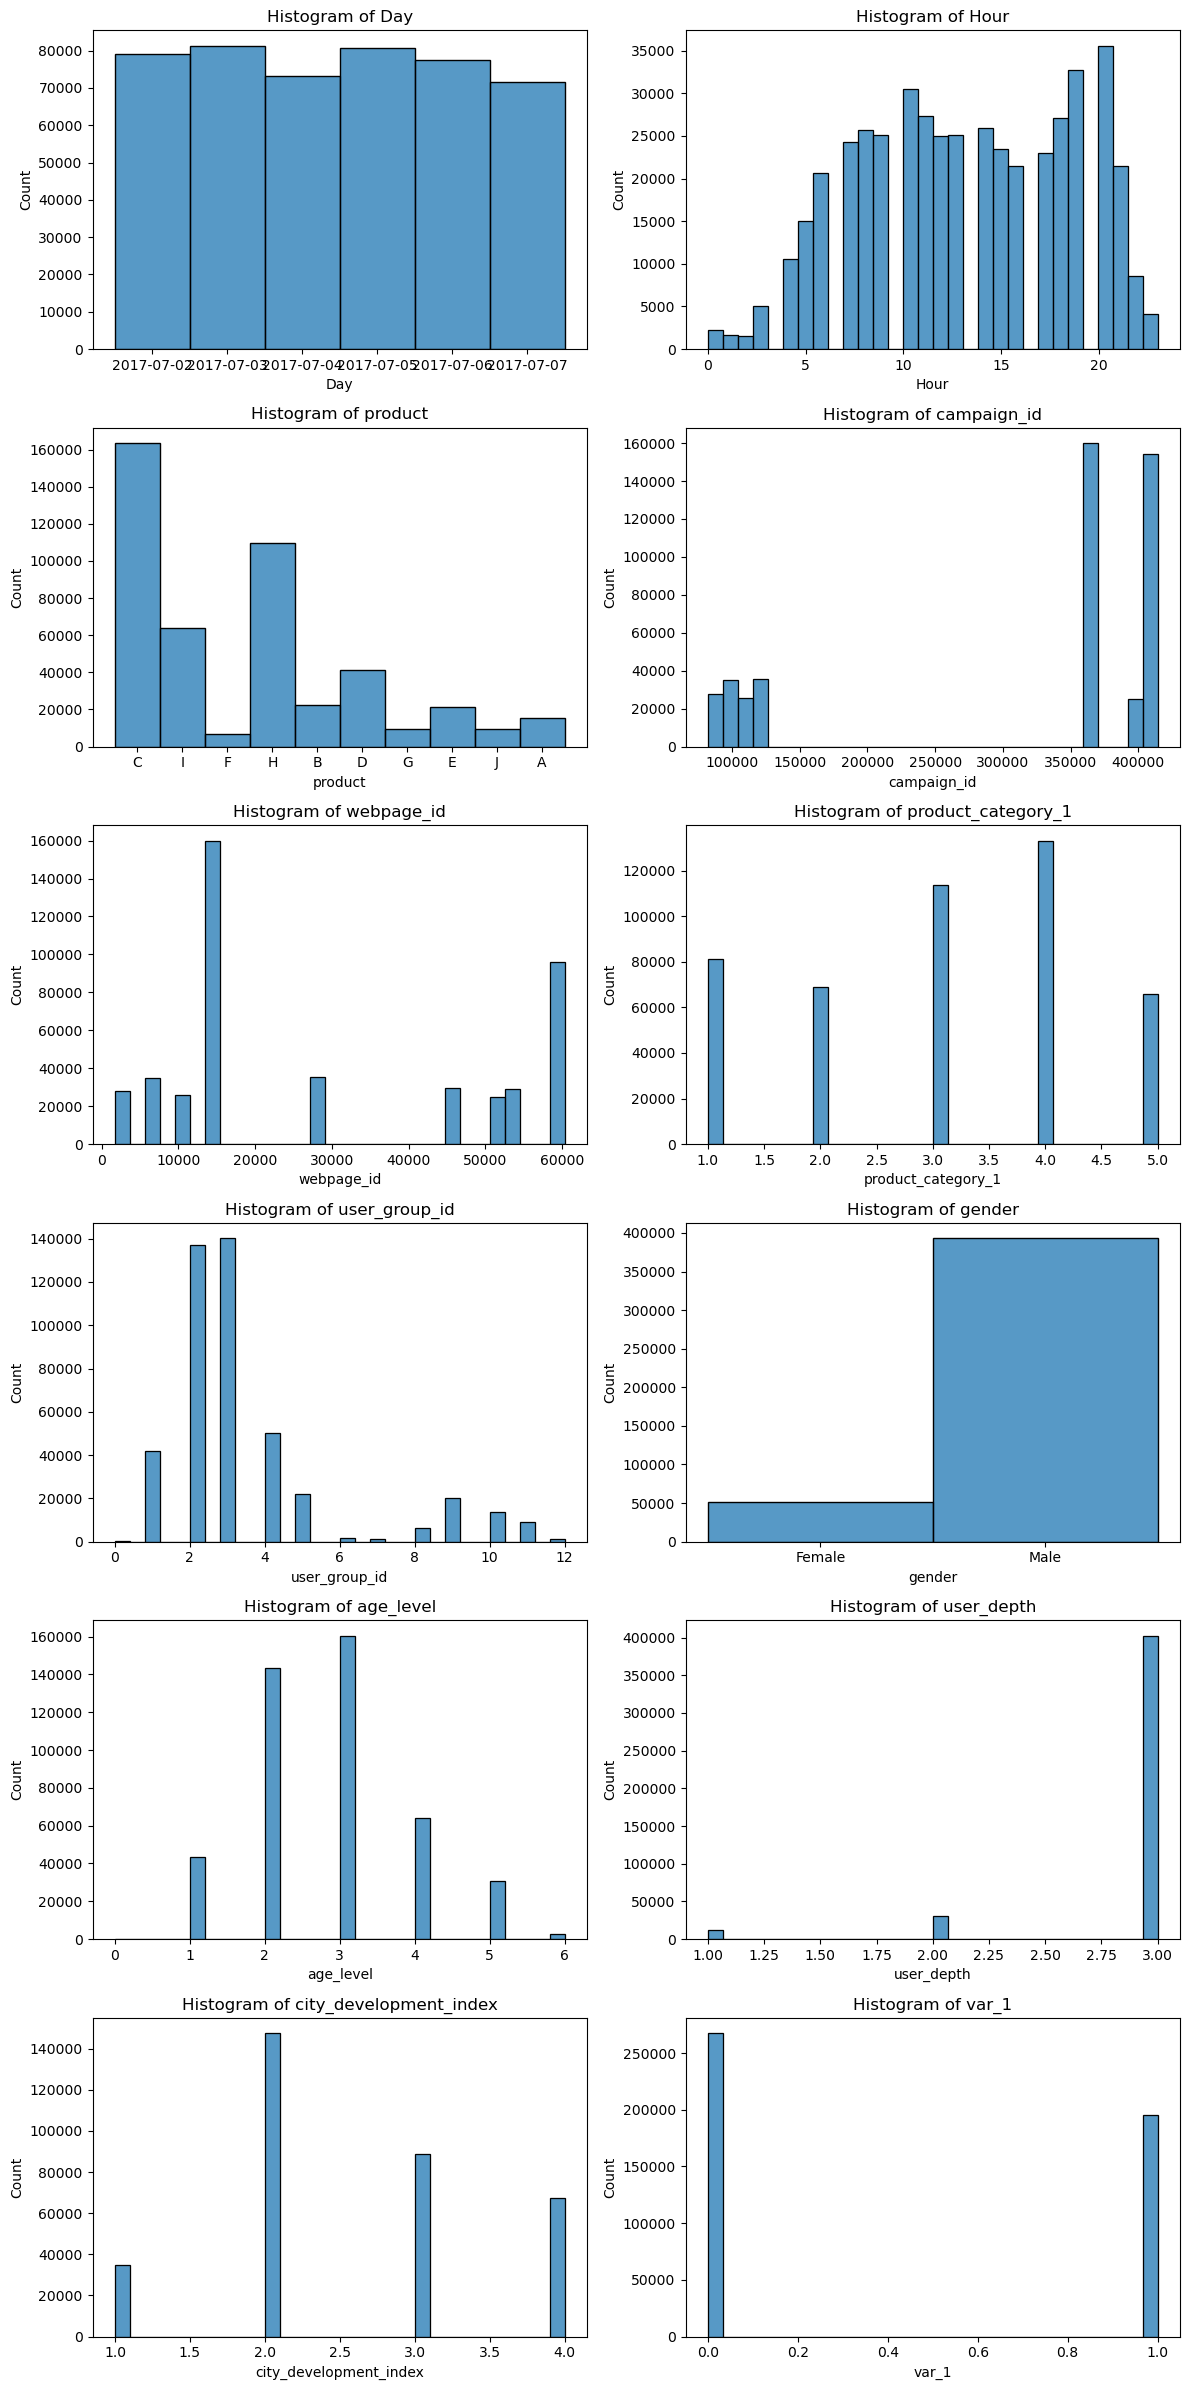

In [14]:
# let have a look on the data distribution
plot_histograms(df, ['Day','Hour', 'product', 'campaign_id', 'webpage_id', 'product_category_1',
 'user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1'])

---
#### Feature Correlation

In [15]:
df = df.drop(columns=["session_id", "user_id", "Hour", "Day"]) # identical col, useless for prediction

In [16]:
df.dtypes
# Convert "product" and "gender" to numerical values using LabelEncoder, as they are non-ordinal categorical variables.

product                    object
campaign_id                 int64
webpage_id                  int64
product_category_1          int64
product_category_2        float64
user_group_id             float64
gender                     object
age_level                 float64
user_depth                float64
city_development_index    float64
var_1                       int64
is_click                    int64
dtype: object

In [17]:
# we need a function to handle nulls values
def handle_nulls(df):
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna('NA_values', inplace=True)
    return df
    
df = handle_nulls(df)

/var/folders/g9/l0616y1j30746l232536wr2r0000gn/T/ipykernel_34813/2998503505.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('NA_values', inplace=True)
/var/folders/g9/l0616y1j30746l232536wr2r0000gn/T/ipykernel_34813/2998503505.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [18]:
# we need labelencoder
le = LabelEncoder()

df[['product','gender','campaign_id','webpage_id','user_group_id']] = df[['product','gender','campaign_id','webpage_id','user_group_id']].apply(LabelEncoder().fit_transform)

In [19]:
df.corr()['is_click'].sort_values()
# get some feelings

product_category_1       -0.016531
age_level                -0.009243
user_group_id            -0.007850
product_category_2       -0.003381
city_development_index   -0.003083
user_depth               -0.001993
product                   0.003258
gender                    0.004606
var_1                     0.011296
campaign_id               0.024836
webpage_id                0.039349
is_click                  1.000000
Name: is_click, dtype: float64

---
### Functions for evaluation

In [20]:
def evaluation_summary(test, pred):
    accuracy = accuracy_score(test, pred) #this will be misleaded by unbalance dataset
    print("Accuracy Score:", accuracy)

    auc_score = roc_auc_score(test, pred) #this will be misleaded by unbalance dataset
    print("AUC Score:", auc_score)

    f1 = f1_score(test, pred)
    print("f1 Score:", f1)

    ap_score  = average_precision_score(test, pred)
    print("AP Score:", ap_score)

---
#### Baseline Model - Training
(Without Resampling) 

In [21]:
# Split the data into features (X) and target (y)
X = df.drop(['is_click'], axis=1)
y = df['is_click']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
# train the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# predict
y_pred = rf.predict(X_test)

In [24]:
evaluation_summary(y_test, y_pred)

Accuracy Score: 0.9322354007705673
AUC Score: 0.5001829369815434
f1 Score: 0.0028585040495474035
AP Score: 0.06687708963872487


Imbalanced data can mislead accuracy and AUC scores, obscuring model performance.

---
#### Features Importances
Understanding each feature’s contribution to decision tree creation.

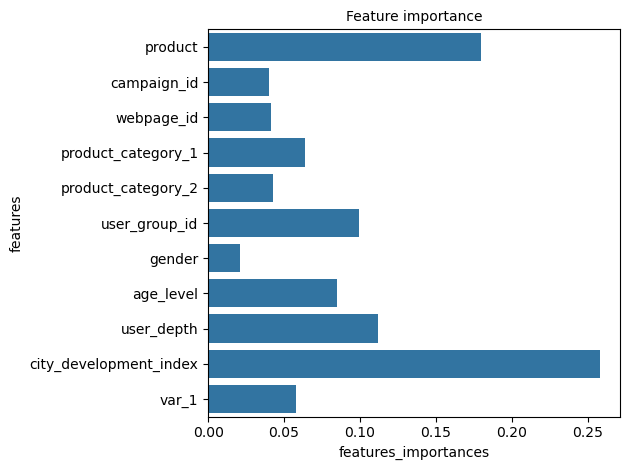

In [25]:
importances = rf.feature_importances_
feature_names = X_train.columns

forest_importances = pd.DataFrame(importances, index=feature_names).reset_index()
forest_importances.columns = ['features', 'features_importances']

fig, ax = plt.subplots()
sns.barplot(data=forest_importances, x='features_importances', y='features')
ax.set_title("Feature importance", fontsize=10)
fig.tight_layout()


---
#### Revised Model - Resampling

SMOTETomek combines SMOTE for oversampling the minority class with synthetic data and Tomek Links for removing noisy, closely paired samples, balancing the dataset and improving classifier performance. Relying solely on SMOTE risks introducing noise alongside quality data due to the small minority class.

In [26]:
sm = SMOTETomek(random_state=42, tomek=TomekLinks(sampling_strategy='majority'))

X_res, y_res = sm.fit_resample(X_train, y_train)
y_train.value_counts(), y_res.value_counts()

(is_click
 0    345495
 1     25137
 Name: count, dtype: int64,
 is_click
 1    345495
 0    345464
 Name: count, dtype: int64)

In [27]:
# train the model
rf = RandomForestClassifier()
rf.fit(X_res, y_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
# predict
y_res_pred = rf.predict(X_test)
evaluation_summary(y_test, y_res_pred)

Accuracy Score: 0.5878759753504786
AUC Score: 0.5519566645426138
f1 Score: 0.1420772393340972
AP Score: 0.07484918003960903
